# Introduction

Using XGBoost and Randomforest to build a collection of boosted trees to predict if a customer will stop using a company's service. Telco Churn dataset is from the IBM Base Samples. The purpose of this Ex is to predict if someone will stop using Telco's services by using a variety of continuous and categorical datatypes. 

About the data:

1.Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

2.Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

3.Demographic info about customers – gender, age range and if they have partners or dependents

Catergorising these variables is pretty important, this helps to investigate the interrelation between them, dimension reducing and interpretation.


1. Missing data
2. Exploratory data analysis
3. Formatting data  
   One Hot Encoding
   Converting data into int, float, bool

4. From preliminary model to optimised model using CV and GridSearch
5. Drawing, interpreting and evaluating



Result based on which metric is used to optimise. 

Recall - 84%

F1 - 65%

AUC - 85%

Accuracy - 86% (Doesn't make sense for this case)







In [2]:
import os
for dirname, _, filename in os.walk('/Documents/Excercise'):
    for file in filename:
        print(os.path.join(dirname, file))
        
        
#list all file under the path

In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,make_scorer,f1_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance

import eli5
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
sns.set()

    

In [40]:
df = pd.read_csv('/Users/hengzizhao/Documents/Excercise/Telco_customer_churn.csv')
df.head(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [7]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

33 The last 5 variables contain exit interview information and should not be included for prediction. Having an exit interview means someone has churned, this 'forward-looking' information needs to be avoided.

In [41]:
df.drop(['Churn Label','Churn Score','CLTV','Churn Reason'],axis= 1, inplace= True)

## 1.Dataset profiling

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [7]:
df.describe()
# stats of numeric data. For postcode, lat and lon, this doesn't mean much

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000


In [8]:
df.describe(include=[object]).loc['unique']

#variables only having 1 value are not useful, should remove.

CustomerID           7043
Country                 1
State                   1
City                 1129
Lat Long             1652
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Total Charges        6531
Name: unique, dtype: object

In [15]:
df.describe(include=[object]).columns 
# print(*(df.iloc[:, i].unique() for i in range(9,26)))

Index(['CustomerID', 'Country', 'State', 'City', 'Lat Long', 'Gender',
       'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Total Charges'],
      dtype='object')

Count is a flag variable, the customers are all from California, but City has 1129 values, may be useful.

In [42]:
df.drop(['CustomerID','Count','Country','State','Lat Long','City','Zip Code','Latitude','Longitude'], axis=1, inplace= True)  

#CustomerID is also not useful, lat long is duplicated information

These variables may not be useful, lat long is duplicated information

In [6]:
#list relevant categorical variables 

col_name = df.describe(include=[object]).columns.to_list()


In [7]:
# check if their value except 'City' and 'Total Charges'
print('=============Unique Value for Categorical Data========================')
print(*('{}:{}'.format(i, df[i].unique()) for i in col_name[1:-1]),sep='\n') 

=============Unique Value for Categorical Data========================
Senior Citizen:['No' 'Yes']
Partner:['No' 'Yes']
Dependents:['No' 'Yes']
Phone Service:['Yes' 'No']
Multiple Lines:['No' 'Yes' 'No phone service']
Internet Service:['DSL' 'Fiber optic' 'No']
Online Security:['Yes' 'No' 'No internet service']
Online Backup:['Yes' 'No' 'No internet service']
Device Protection:['No' 'Yes' 'No internet service']
Tech Support:['No' 'Yes' 'No internet service']
Streaming TV:['No' 'Yes' 'No internet service']
Streaming Movies:['No' 'Yes' 'No internet service']
Contract:['Month-to-month' 'Two year' 'One year']
Paperless Billing:['Yes' 'No']
Payment Method:['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Total Charges:['108.15' '151.65' '820.5' ... '7362.9' '346.45' '6844.5']
Churn Label:['Yes' 'No']


## 2. Missing data
Identify missing data, then format, but when it comes to impute missing data, understanding the reason of missingness is important, also different ways of filling in missing data have different impact on different models. XGBoost has default behavior for missing data

Firstly, vertify the data type is what expected. 'Total Charges' is supposed to be numeric, but it is $object$ suggesting it is not all numeric value

In [125]:
df['Total Charges'].unique()

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

In [126]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'])

# Cannot convert to numeric directly as there are empty values

ValueError: Unable to parse string " " at position 2234

In [7]:
df[df['Total Charges']==' ']

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
2234,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


## Identify missingness  MCAR/MAR/MNAR

11 people have Total Charges == ' ', because 'Tenure Months' = 0, also 'Churn Value' = 0. This may be because they are new customers? Removing them should be considered, because it can be noise or set 'Total Charges' = 0 for now. 11 is 0.15% of the total sample, this shouldn't have significant effect on the prediction. If it is extremely unbalanced data, maybe it is another story. 

In [43]:
# reformat the value of 'Total Charges'
df.loc[df['Total Charges']==' ', 'Total Charges'] = 0
df['Total Charges'] = pd.to_numeric(df['Total Charges'])
df['Total Charges'].dtype

dtype('float64')

In [9]:
df.loc[df['Tenure Months']==0]   #verify missing data

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
2234,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,...,Two year,Yes,Bank transfer (automatic),52.55,,No,0,36,2578,NaN
2438,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,...,Two year,No,Mailed check,20.25,,No,0,68,5504,NaN
2568,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,...,Two year,No,Mailed check,80.85,,No,0,45,2048,NaN
2667,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,...,Two year,No,Mailed check,25.75,,No,0,48,4950,NaN
2856,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,...,Two year,No,Credit card (automatic),56.05,,No,0,30,4740,NaN
4331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,Two year,No,Mailed check,19.85,,No,0,53,2019,NaN
4687,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,...,Two year,No,Mailed check,25.35,,No,0,49,2299,NaN
5104,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,Two year,No,Mailed check,20.00,,No,0,27,3763,NaN
5719,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,One year,Yes,Mailed check,19.70,,No,0,69,4890,NaN
6772,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,...,Two year,No,Mailed check,73.35,,No,0,44,2342,NaN


In [44]:
df.replace(' ','_', regex= True, inplace = True) # add underscore for drawing figures conveniently 

# 3. Exporatory data analysis
  Before encoding the data for modelling, EDA should be conducted to get some insight and see what hypothesis we may   propose. Though this could be difficult for high dimentional data (computer version, NLP)

In [131]:
df[df['Churn Value']==1]

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,Male,No,No,No,12,Yes,No,DSL,No,No,No,Yes,Yes,No,One_year,Yes,Electronic_check,59.80,727.80,1
1865,Female,No,No,No,9,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank_transfer_(automatic),44.20,403.35,1
1866,Male,Yes,No,No,1,Yes,Yes,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,75.75,75.75,1
1867,Female,No,No,No,67,Yes,Yes,Fiber_optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit_card_(automatic),102.95,6886.25,1


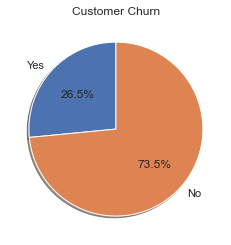

In [11]:

labels = 'Yes','No'
sizes = [len(df[df['Churn Value']==1])/len(df)*100,len(df[df['Churn Value']==0])/len(df)*100]


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set(aspect = 'equal',title = 'Customer Churn')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Imbalanced data

In [ ]:
#1. numeric variables and churn 
    Tenure
    Monthly charges
    Total charges

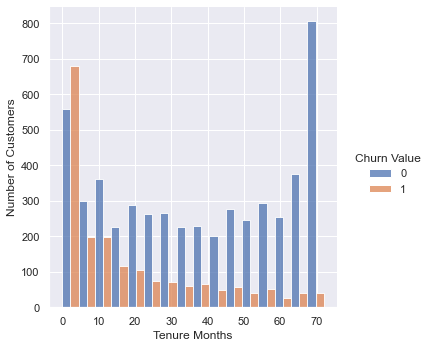

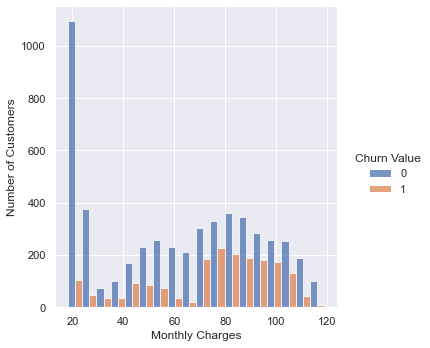

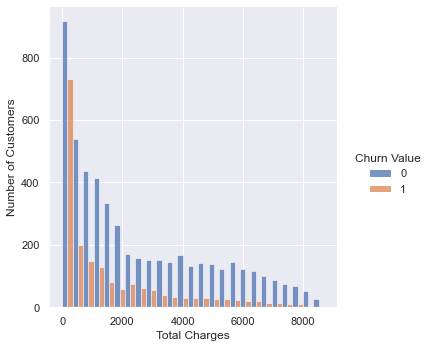

In [12]:
sns.set_theme()
sns.displot(df, x='Tenure Months', hue='Churn Value', multiple='dodge').set(ylabel='Number of Customers')
sns.displot(df, x='Monthly Charges', hue='Churn Value', multiple='dodge').set(xlabel='Monthly Charges', ylabel='Number of Customers')
sns.displot(df, x='Total Charges', hue='Churn Value', multiple='dodge').set(xlabel='Total Charges', ylabel='Number of Customers')

# Observation 
Tenure and Monthly charges may be good predictors, Total charges is an aggregated value.


## Some categorical variables 


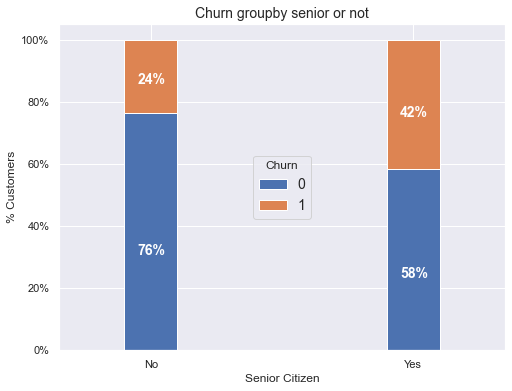

In [13]:
seniority_churn = df.groupby(['Senior Citizen','Churn Value']).size().unstack()

ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                )
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn group by senior or not',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

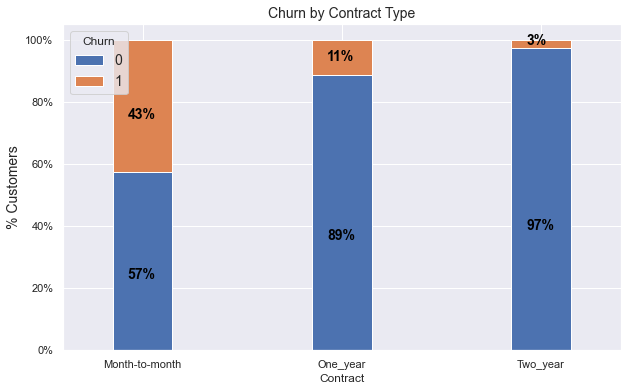

In [14]:
contract_churn = df.groupby(['Contract','Churn Value']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'black',
               weight = 'bold',
               size = 14)

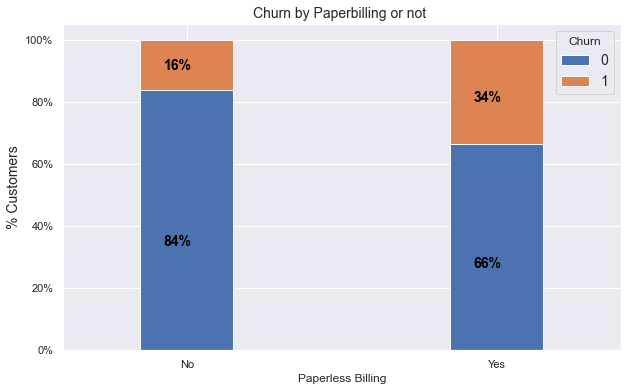

In [55]:
bill_churn = df.groupby(['Paperless Billing','Churn Value']).size().unstack()

ax = (bill_churn.T*100.0 / bill_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Paperbilling or not ',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'black',
               weight = 'bold',
               size = 14)

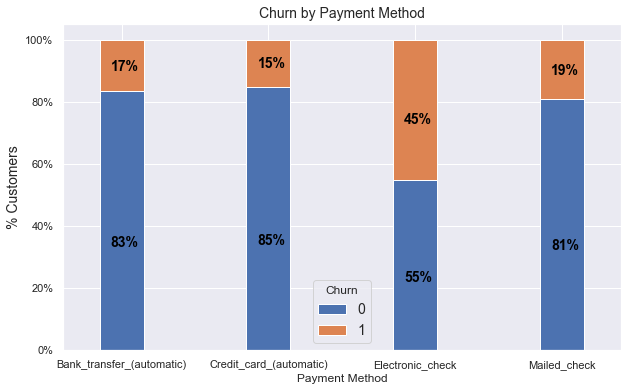

In [56]:
payment_churn = df.groupby(['Payment Method','Churn Value']).size().unstack()

ax = (payment_churn.T*100.0 / payment_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Payment Method',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'black',
               weight = 'bold',
               size = 14)

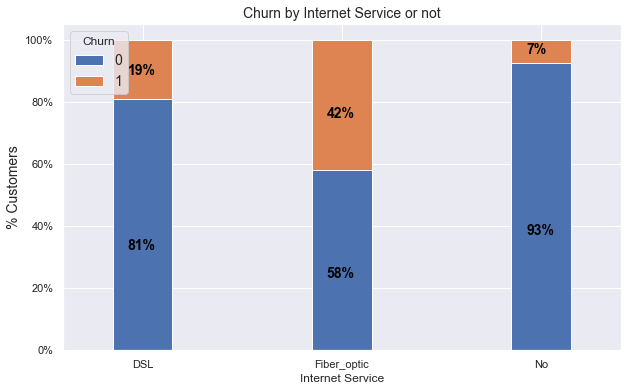

In [58]:
internet_churn = df.groupby(['Internet Service','Churn Value']).size().unstack()

ax = (internet_churn.T*100.0 / internet_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Internet Service or not',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'black',
               weight = 'bold',
               size = 14)

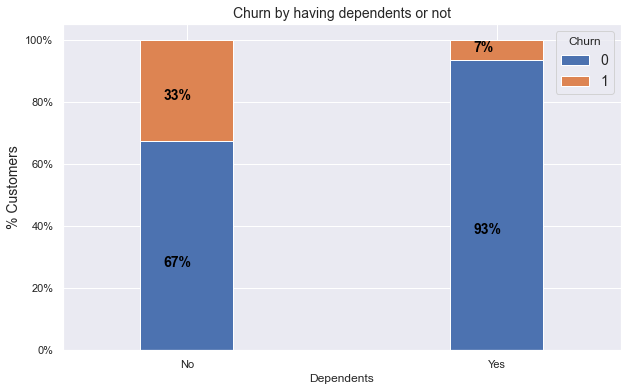

In [67]:
De_churn = df.groupby(['Dependents','Churn Value']).size().unstack()

ax = (De_churn.T*100.0 / De_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by having dependents or not',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'black',
               weight = 'bold',
               size = 14)

# Observation of EDA
1. For Demographic: customers having partners or dependents shows a difference. People who have partners or dependents seem to be less likely to churn; 

2. For service: phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.

   A. The more services they are subscribled to, the less likely they are to churn. So in terms of feature engineering, online security, online backup, device protection, tech support, and streaming TV and movies, these variables may be considiered as one variable.
   
   B. For internet service: people who have fibre_optic seem to be more likely to churn:
   
      Hypothesis 1: people who have fibre may care more about quality of internet service, such as speed/ if the internet stable or not, so they are more criticising.
      
      Hypothesis 2: Having fibre_optic implies better infrustructure in the area, so there is more competition? It is easier for people to switch between companies? I think this is the more likely reason.

3. For Customer account information:contract, payment method, paperless billing, monthly charges, and total charges.

   A.monthly charges, the higher -> churn
   
   B.contract, the more flexible (month-to-month) -> churn
   
   C.Payment method, electronic check -> churn
   
   D.Paperless billing -> churn



Conclusion: tree based models (e.g.,Random forest/ XGBoost) may be a better option if we don't want to do much feature engineering. SVM? NN?  But if we do, logistic regression may be considered. 


# 4. Formatting data and modelling:
XGBoost is powerful, but not sure if it does a good job on such small dataset.

1.Formatting predictor and target data

2.OHE:one hot encodeing for categorical data

  All of columns having categorical data have been verified to make sure they only contain accepted categories.

In [45]:
X = pd.get_dummies(df.iloc[:,:-1])
y = df['Churn Value']

In [46]:
X.shape

(7043, 46)

Need to verify y only contains 1 and 0. Because XGBoost tries to minimise cost function, then it attempts to work out the value as either 1 or 0 based on which leads to less mistakes. However as I have identified the reason of missingness, So need to make sure empty values are replaced with 0

In [10]:
y.unique()  

array([1, 0])

Since the dataset is inbalanced, we should use stratification when splitting the dataset. Instead of determining the optimal number of trees with cross validation, use early stopping to stop building trees when they no longer improve the performance. 

Start with a preliminary model.

In [47]:
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state = 12,stratify = y)

In [23]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', missing = None, seed = 12)
clf_xgb.fit(X_train,y_train,verbose = True,early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(X_test,y_test)])

[0]	validation_0-aucpr:0.67313
[1]	validation_0-aucpr:0.69066
[2]	validation_0-aucpr:0.68808
[3]	validation_0-aucpr:0.69219
[4]	validation_0-aucpr:0.69359
[5]	validation_0-aucpr:0.68911
[6]	validation_0-aucpr:0.69601
[7]	validation_0-aucpr:0.70207
[8]	validation_0-aucpr:0.70279
[9]	validation_0-aucpr:0.70092
[10]	validation_0-aucpr:0.70126
[11]	validation_0-aucpr:0.70350
[12]	validation_0-aucpr:0.70224
[13]	validation_0-aucpr:0.70372
[14]	validation_0-aucpr:0.70287
[15]	validation_0-aucpr:0.70202
[16]	validation_0-aucpr:0.70225
[17]	validation_0-aucpr:0.70146
[18]	validation_0-aucpr:0.69830
[19]	validation_0-aucpr:0.69718
[20]	validation_0-aucpr:0.69350
[21]	validation_0-aucpr:0.69049
[22]	validation_0-aucpr:0.68921
[23]	validation_0-aucpr:0.68938


/Users/hengzizhao/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=12,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=12,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Apparently in this case, we care more about how many people may churn. If we want to implement a marketing strategy, we want to know how many people identified to churn will actually churn, because marketing has cost. In other words, we care about if the model is good at marking positive case as positive and not wrongly marking negative cases as positive. So AUPRC is a better option for performance evaluation.

AUROC is widely used, though it is important to be aware of the limitations of AUROC. AUROC can be “excessively optimistic” about the performance of models that are built for data sets with a much larger number of negative examples than positive examples.

In cases with many more negative examples than positive examples, a big improvement in the number of false positives only leads to a small change in the false positive rate. This is because the false positive rate is calculated as:
$ false   positives  /  ( false  positives  +  true  negatives ) $ and if we have a huge number of true negatives in the denominator, it’s going to be really hard to change the false positive rate only by changing the false positives.

AUPRC:

$ Recall  = TPR  =  True  Positives  /  ( True  Positives  +  False  Negatives )$. Recall can be thought of as the ability of the classifier to correctly mark all positive examples as positive.

$ Precision  =  True  Positives  /  ( True  Positives  +  False  Positives )$. Precision can be thought of as the ability of the classifier not to wrongly label a negative sample as positive

Because PR curves don’t use true negatives anywhere, the AUPRC won’t be swamped by a large proportion of true negatives in the data. 

AUPRC can often be most useful when its baseline is lowest, because there are many datasets with large numbers of true negatives in which the goal is to handle the small fraction of positives as best as possible.

Now check the **Confusion Matrix** of testing dataset.

f1-score: 0.6148409893992932
recall 0.5588865096359743
accuracy: 0.8143100511073254
roc_auc: 0.7326890044315885


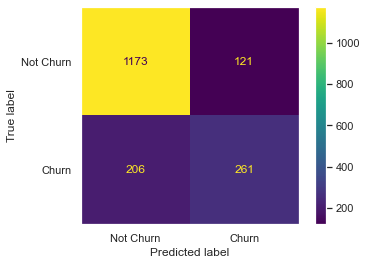

In [36]:
plot_confusion_matrix (clf_xgb, X_test, y_test, display_labels=['Not Churn', 'Churn'])
plt.grid (False)
pred = clf_xgb.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('accuracy:',accuracy_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))

Though the accuracy is 81.4% and 70% of 'churn' is true 'churn', only 56% true 'churn' is identified. We want to capture more true 'churn'. XGBoost has 'scale_pos_weight' to help with imbalanced data. It tries to give more weight on true 'churn'. 

## GridSearchCV + XGBoost + Earlystopping
Improve prediction using **GridSearchCV**. max_depth,learning_rate,gamma(encourage pruning),reg_lambda(regularise variables).

In [15]:
# Since optimization takes time, run it sequantially on subset of potiential parameters.

param_grid = {'max_depth': [3,4,5],
             'learning_rate': [0.1,0.05,0.01],
             'gamma':[0,0.25,0.1],
             'reg_lambda':[0,1.0,10.0],
             'scale_pos_weight':[3]}

# Param_grid = {'max_depth': [3,4,5,6],
#              'learning_rate': [0.1,0.05,0.01,0.001],
#              'gamma':[0,0.25,0.1],
#              'reg_lambda':[0,1.0,10.0],
#              'scale_pos_weight':[1,3,5]}


# 3 - folds
# a random 90% of subset of the data 
# 70% features for each tree


optimal_param2 = GridSearchCV(estimator= xgb.XGBClassifier(objective= 'binary:logistic',
                                                         seed = 12, subsample = 0.9,
                                                         colsample_bytree = 0.7,use_label_encoder=False),
                            param_grid= param_grid,verbose= 0, n_jobs= 10, cv=3)

optimal_param2.fit(X_train, y_train, early_stopping_rounds =10, eval_metric = 'aucpr', eval_set = [(X_test,y_test)])

[0]	validation_0-aucpr:0.63504
[1]	validation_0-aucpr:0.68333
[2]	validation_0-aucpr:0.67764
[3]	validation_0-aucpr:0.67378
[4]	validation_0-aucpr:0.67544
[5]	validation_0-aucpr:0.68158
[6]	validation_0-aucpr:0.68297
[7]	validation_0-aucpr:0.68227
[8]	validation_0-aucpr:0.69173
[9]	validation_0-aucpr:0.68758
[10]	validation_0-aucpr:0.69081
[11]	validation_0-aucpr:0.69183
[12]	validation_0-aucpr:0.69355
[13]	validation_0-aucpr:0.69612
[14]	validation_0-aucpr:0.69645
[15]	validation_0-aucpr:0.69569
[16]	validation_0-aucpr:0.69657
[17]	validation_0-aucpr:0.69692
[18]	validation_0-aucpr:0.69670
[19]	validation_0-aucpr:0.69777
[20]	validation_0-aucpr:0.70052
[21]	validation_0-aucpr:0.70165
[22]	validation_0-aucpr:0.69872
[23]	validation_0-aucpr:0.69970
[24]	validation_0-aucpr:0.69995
[25]	validation_0-aucpr:0.70081
[26]	validation_0-aucpr:0.70106
[27]	validation_0-aucpr:0.70148
[28]	validation_0-aucpr:0.69948
[29]	validation_0-aucpr:0.69965
[30]	validation_0-aucpr:0.70085


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=12,
                                     subsample=0.9, tree_metho

In [16]:
optimal_param2.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 5,
 'reg_lambda': 0,
 'scale_pos_weight': 3}

In [48]:
clf_xgb2 = xgb.XGBClassifier(seed = 12, objective = 'binary:logistic', gamma = 0.25,learning_rate = 0.1,
                            max_depth = 5, scale_pos_weight = 3, reg_lambda = 0, subsample = 0.9,colsample_bytree = 0.5)
clf_xgb2.fit(X_train,y_train,verbose = True, early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(X_test,y_test)])

[0]	validation_0-aucpr:0.55703
[1]	validation_0-aucpr:0.67412
[2]	validation_0-aucpr:0.66754
[3]	validation_0-aucpr:0.67133
[4]	validation_0-aucpr:0.67810
[5]	validation_0-aucpr:0.69204
[6]	validation_0-aucpr:0.68969
[7]	validation_0-aucpr:0.69211
[8]	validation_0-aucpr:0.69349
[9]	validation_0-aucpr:0.69319
[10]	validation_0-aucpr:0.69406
[11]	validation_0-aucpr:0.69928
[12]	validation_0-aucpr:0.69693
[13]	validation_0-aucpr:0.69878
[14]	validation_0-aucpr:0.69767
[15]	validation_0-aucpr:0.69694
[16]	validation_0-aucpr:0.69709
[17]	validation_0-aucpr:0.69758
[18]	validation_0-aucpr:0.69855
[19]	validation_0-aucpr:0.69778
[20]	validation_0-aucpr:0.69700
[21]	validation_0-aucpr:0.69661


/Users/hengzizhao/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=12,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=3, seed=12,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

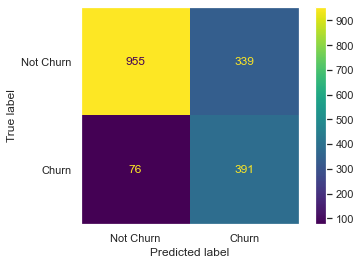

In [49]:
plot_confusion_matrix (clf_xgb2, X_test, y_test, display_labels=['Not Churn', 'Churn'])
plt.grid (False)

In [50]:
pred = clf_xgb2.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))

f1-score: 0.6532999164578112
recall 0.8372591006423983
roc_auc: 0.7876403694865779


# Small summary

As mentioned previously, this dataset is imbalanced. From the perspective of business, identifing more 'churn' who actually will churn (and less 'churn' who won't actually churn) will be more profitable than just getting high accuracy and roc_auc. 'f1 - score' and 'recall' are massively improved. The new XGB is better than the preliminary one. 

The other thing need to consider is the net profit of marketing, the new XGB correctly finds an extra 130 'true churn', but also find an extra 218 'false churn'. Therefore, if we simply assume the profit per head is 2.67+ times higher than the cost per head and marketing will definitely help to keep the targeted customers, then we should do the marketing.  

## RandomForest

In [28]:
rf = RandomForestClassifier(random_state=12)

param_grid = {'n_estimators':[500,1000],
             'max_depth':[3,4,5,6],
             'bootstrap':[True], 'class_weight':[{1:w} for w in [1,1.5,2]] }

rfclf = GridSearchCV(rf,param_grid= param_grid,scoring = 'f1', cv=3)
rfclf.fit(X_train,y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12),
             param_grid={'bootstrap': [True],
                         'class_weight': [{1: 1}, {1: 1.5}, {1: 2}],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [500, 1000]},
             scoring='f1')

In [29]:
print("Best parameters \n" + str(rfclf.best_params_))

Best parameters 
{'bootstrap': True, 'class_weight': {1: 2}, 'max_depth': 6, 'n_estimators': 500}


In [38]:
pred = rfclf.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))
#print('accuracy_score:',accuracy_score(y_test,pred))

f1-score: 0.6522148916116872
recall 0.7408993576017131
roc_auc: 0.7746227854469153


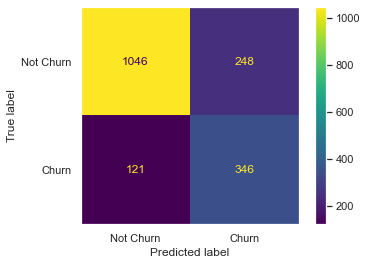

In [32]:
plot_confusion_matrix (rfclf, X_test, y_test, display_labels=['Not Churn', 'Churn'])
plt.grid (False)